In [1]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, BasicAer, IBMQ
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import random_statevector

In [2]:
def even_block():
    #set of 4 initial Rz gates and then a combination of Cz gates (two-qubit gate)
    pass

def odd_block(): 
    
    #set of 4 Rx gates applied to each qubit
    pass
    
def layer_block():
    
    #an even block + odd block -> one layer
    pass

In [3]:
#qiskit even block
def even_block(qc):
    
    for i in range(4):
        qc.rz(np.pi/2,i) #this must be a parametrized circuit 4 four different angles, e.g theta[i]
    
    tuples = [(i,j) for i in range(4) for j in range(4) if i < j]

    for tup in tuples:
        qc.cz(tup[0], tup[1])

In [4]:
#qiskit  odd block
def odd_block(qc):
    
    for i in range(4):
        qc.rx(np.pi/2, i)

In [5]:
def layer(qc):
    
    odd_block(qc)
    even_block(qc)
    qc.barrier()

In [6]:
def built_circuit(number_layers):
    
    qc = QuantumCircuit(4)
    for i in range(number_layers):
        layer(qc)
    return qc

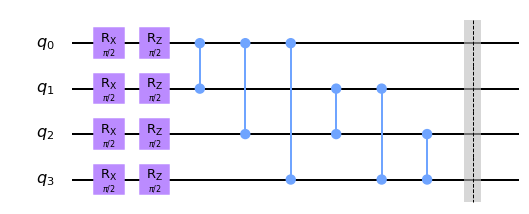

In [7]:
qc = built_circuit(1)

qc.draw(output='mpl')

In [8]:
random_statevector(2, seed = 42)

Statevector([ 0.30719863-0.37807185j, -0.28356911-0.82600196j],
            dims=(2,))

## Simple example - Optimize the circuit for creating a Bell state

In [9]:
#trivial solution
qr = QuantumRegister(2)
cr = ClassicalRegister(2)
qc = QuantumCircuit(qr, cr)
qc.h(0) # Put qubit a into state |+>
qc.cx(0,1) # CNOT with a as control and b as target
qc.measure(0,0)
qc.measure(1,1)
qc.draw()

┌───┐     ┌─┐   
q0_0: ┤ H ├──■──┤M├───
      └───┘┌─┴─┐└╥┘┌─┐
q0_1: ─────┤ X ├─╫─┤M├
           └───┘ ║ └╥┘
c0: 2/═══════════╩══╩═
                 0  1

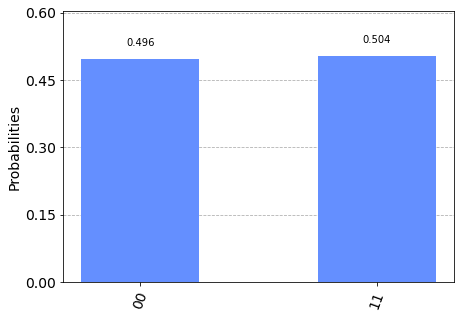

In [10]:
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts()
plot_histogram(counts)

In [11]:
dev = qml.device('default.qubit', wires = 2)
qml.QubitStateVector(np.array([]), wires = 1)

QubitStateVector(tensor([], dtype=float64, requires_grad=True), wires=[1])

In [22]:
@qml.qnode(dev)
def circuit(params):
    A = np.array([[ 0.5, 0.5],
           [ 0.5,  0.5]])
    qml.U3(params[0], params[1], params[2], wires = 0)
    
    return qml.expval(qml.Hermitian(A, wires = 0))

In [23]:
params = [np.pi*0.5, 0, 0.3]
a = circuit(params)
a

0.9999999999999996

In [14]:
def cost(x):
    
    return (1.0 - circuit(x))

In [15]:
init_params = np.array([0.7, 0, 0.3])
cost(init_params)

0.17789115638115482

In [16]:
opt = qml.GradientDescentOptimizer(stepsize = 0.4)

steps = 100

params = init_params

In [17]:
for i in range(steps):
    
    params = opt.step(cost, params)
    
print(params)

[1.57079633 0.         0.3       ]


In [18]:
cost(params)

4.440892098500626e-16

In [24]:
Z = np.random.random((1,2)) + np.random.random((1,2)) * 1j
Z.shape

(1, 2)

In [25]:
#the main idea here is to define the observable 

$|\psi\rangle \rightarrow |\psi\rangle \langle \psi |$

In [27]:
target_distr = np.random.rand(2)
target_distr /= sum(target_distr)

In [28]:
target_distr

tensor([0.50504943, 0.49495057], requires_grad=True)